#                                                                       TP MATE 3


### Integrantes: Lucia Sannuto, Valentin Fuccenecco y Valentin Pugliese

La idea del trabajo es mostrar de manera gráfica la relacion entre difrentes artículos de wikipedia, a traves de los "links azules" que se encuentran dentro de cada artículo. Para ello utilizamos requests, bs4 y reGex para la obtención y el parseo de las páginas y posteriormente networkX para graficarlas.

El concepto es simple: Cada articulo esta representado por un nodo en el gráfico, si uno referencia a otro se dibuja con un vertice direccional entre ambos nodos

In [2]:
# Importaciones
import random
import requests as rq
from bs4 import BeautifulSoup
import re
import networkx as nx
import pickle
import matplotlib.pyplot as plt

# Abro la base de datos con mis paginas almacenadas y la cargo en memoria
with open("data.pickle", "rb") as f:
     guardados = ((pickle.load(f)))

# Paginas almacenadas
print(f"Cantidad de paginas almacenadas: {len(guardados)}")

Cantidad de paginas almacenadas: 4046


Para agilizar un poco el proceso de parseo, guardo en un diccionario de python los html de ciertas paginas de wikipedia y este diccionario luego es guardado en un "pickle", un tipo de archivo binario especial de python. De esta forma me evito hacer un monton de requests a la web, muy util si estoy en un lugar con una mala conexion a internet.

In [3]:

#clases
class Nodo():
    
    # quiero que cuando lo imprima me salga el nombre del objeto (limito los caracteres para el grafico)
    def __repr__(self) -> str:
        return '%.9s' % self.nombre
    
    #cuando se incializa un nodo se crea en el grafico, se le da un nombre, la url de su pagina de wikipedia y se le crea una lista con todos los links dentro de ella
    def __init__(self, nombre) -> None:
        self.nombre = nombre
        # acá se van a almacenar las urls internas
        self.palabras = set()
        self.parsePage(nombre)
    
    #metodo que va a fijarse si dos nodos tienen conexion, osea si uno referencia al otro (opcional a usar)
    def estaEn(self, nodo):
        if self.nombre.lower() in nodo.palabras and nodo.nombre != self.nombre:
            return ((nodo,self))
            
     
    #parsea con bs4 la pagina de wikipedia que le pases, obteniendo los hipervinculos dentro
    def parsePage(self,nombre):
        #el prefijo para siguientes busquedas
        prefijo_wiki = "https://es.wikipedia.org/wiki/"
        url = prefijo_wiki + nombre

        # Me fijo si esta ne mi base de datos de urls
        if self.nombre in guardados.keys():
            page = guardados[self.nombre]
        else:
            page = rq.get(url)
            guardados[self.nombre] = page

        #la parseo en un objeto
        soup = BeautifulSoup(page.content, "html.parser")
        
        #armo una lista con los terminos que yo quiero, en este caso todos los links que refertencian a otra pagina dentro de la wikipedia
        links = soup.find_all('a', attrs={"href": re.compile("^/wiki/")})

        #selecciono a partir de que links me va a interesar revisar (es arbitrario para reducir los link que no me importan, como los de discusion e idiomas del articulo)
        limite_inferior = 30

        ## LIMPIEZA DE DATOS ##
        #obtengo el texto y lo cargo en el set
        for i in links[limite_inferior:]:
            self.palabras.add(i.get_text().lower().replace(" ","_")) # Hay que hacer que no sea caps sensitive y eliminar los espacios para poder usarlos en urls
        
        #remuevo los resultados vacios, el try hace que el remove no me explote el programa
        try:
            self.palabras.remove('')
        except KeyError:
            pass
        
        # remuevo estos links que no me interesan
        try:
            self.palabras.remove("limitación_de_responsabilidad")
        except KeyError:
            pass
        
        # el about usa tampoco me interesa
        try:
            self.palabras.remove("acerca_de_wikipedia")
        except KeyError:
            pass
        
        # filtro aquellos resultados que empiezan con wikipedia y los del isbn, uso regex
        for i in list(self.palabras):
            if re.match(r"^wikipedia", i) or re.match(r"^isbn", i):
                self.palabras.remove(i)
        

Trabajamos con 2 formas de Implementar los gráficos:
- Del tipo central:
    se elige un nodo principa y todo el resto de nodos salen de él, osea que todos son hipervinculos que estan dentro de su html
    
- Del tipo encadenamiento:
    se elige un nodo inicial del cual se extrae otro nodo, a su vez, de este último se va a extrer el siguiente, así sucesivamente.

windows_11
uwp
internet_explorer
navegadores_web
avant_browser
shell_de_internet_explorer
outlook_express
categorías
lccn
completa
lógicas
parménides
britannica
l'encyclopédie
artes_mecánicas
música
ludwig_van_beethoven
hombres
emocional
agresión


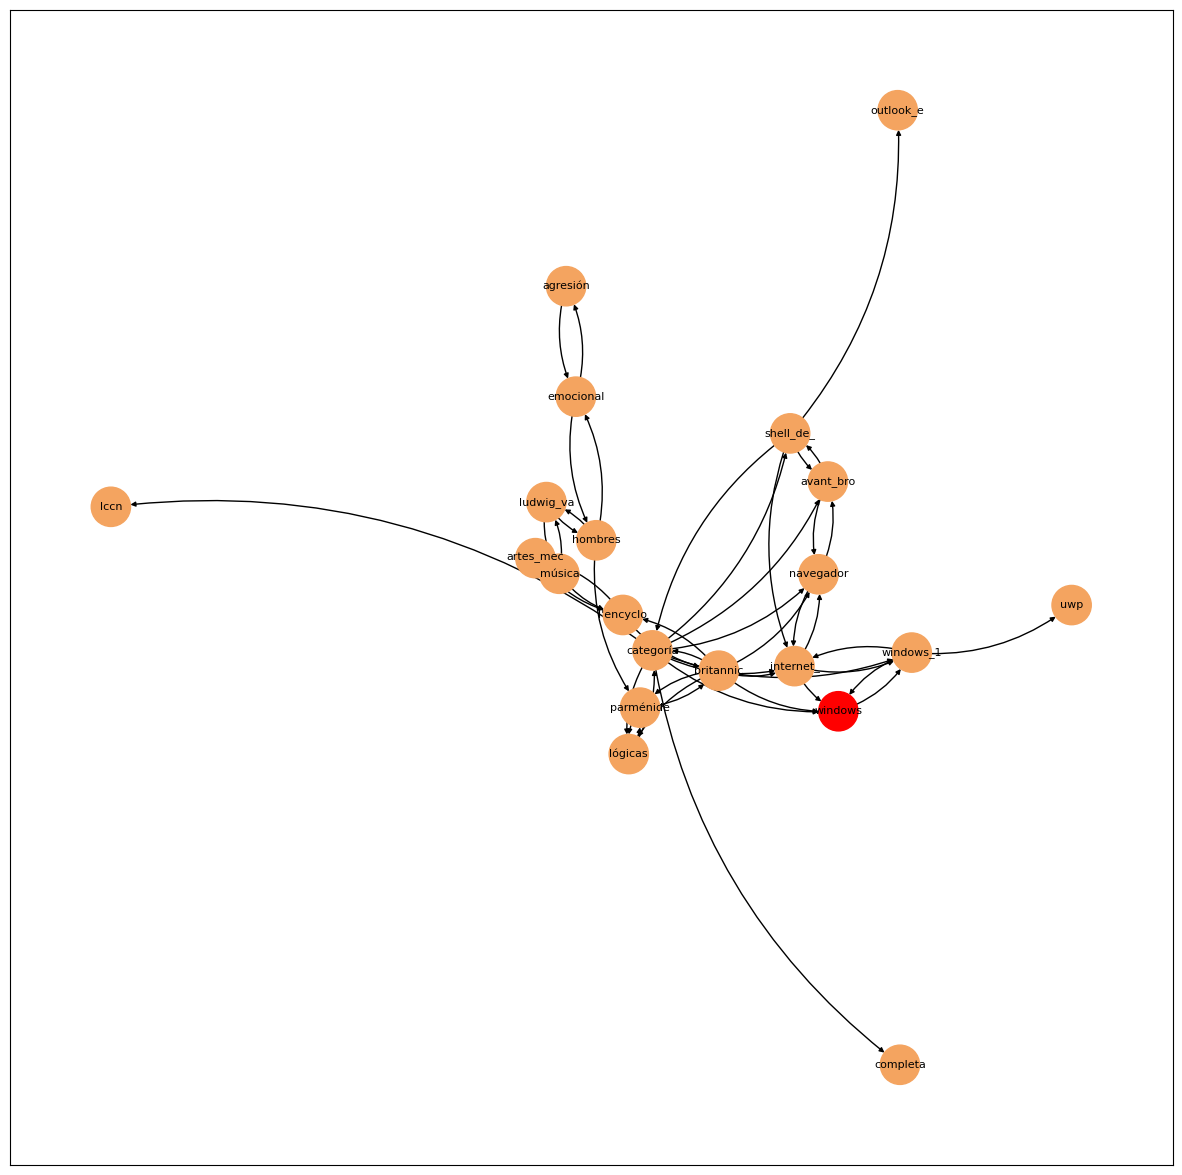

In [8]:
######### Ejemplo con encadenamiento ###############

def logica_nodos(cant_coincidencia,nodo,nodo_anterior,vertices):
 # voy a ejecutar n coincidencias
 for i in range(cant_coincidencia):
    # lo agrego a la lista d enodos
    nodos.append(nodo)
    # lo imprimo para saber nada mas
    print(nodo.nombre)
    # agrego el link entre el ndodo buscado y el nodo de donde salió
    vertices.append((nodo_anterior, nodo))
    
    # si no esta vacio me va a servir para encontrar nuevos nodos
    if (len(nodo.palabras)>0):
        # checkeo con que otros nodos hay relacion (osea que esta en su lista de palabras)
        for i in nodos:
            if nodo.nombre in i.palabras and i.nombre != nodo.nombre:
                vertices.append((nodo,i))
                
        # lo voy a usar para buscar mas nodos, por lo tanto lo tengo que guardar para luego vincularlo
        nodo_anterior = nodo
        
        # consigo un nuevo nodo
        palabras_nodo_anterior = list(nodo_anterior.palabras)
        nodo = Nodo(palabras_nodo_anterior[random.randrange(0, len(palabras_nodo_anterior))])
    else:
        # si elnodo esta vacio uso el anterior y no me intrrumpe la ejecucion del programa
        nodo =  Nodo(random.choice(list(nodo_anterior.palabras)))
 return nodo



nodos = list()             # lista que va a tener todos los nodos del grafico
vertices = list()          # lista que contiene los vertices
grafo = nx.DiGraph()       # creo el grafo

nodo_central = input("Ingrese una palabra para buscar sus coincidencias en Wikipedia! ")
cant_coincidencia = int (input("Ingrese cantidad de coincidencias "))
nodo_maestro = Nodo(nodo_central)
primer_nodo = nodo_maestro

nodos.append(nodo_maestro)              # agrego el nodo maestro a la lista

nodo = Nodo(list(nodo_maestro.palabras)[random.randrange(0,len(nodo_maestro.palabras))])   # obtengo un nodo aleatorio
nodo_anterior = nodo_maestro    # nodo que me va a servir para saber que nodo referencia a cual


# colores de los nodos #
color_nodos_otros = "sandybrown"
color_nodo_central = "red"

nodo = logica_nodos(cant_coincidencia,nodo,nodo_anterior,vertices) # llamo funcion 
   
nodos = set(nodos)            # uso un set para eliminar repeticiones
grafo.add_nodes_from(list(nodos))
grafo.add_edges_from(vertices)

node_colors = [color_nodo_central if nodos == primer_nodo else color_nodos_otros for nodos in grafo.nodes] #color central
pos = nx.spring_layout(grafo)    #disposicion de nodos
labels= nx.get_edge_attributes(grafo,'label')

fig, ax= plt.subplots(figsize=(15,15))  # tamaño de "universo", para el desarrollo del grafo
nx.draw_networkx(grafo, pos, with_labels=True, node_size=800, font_size=8,node_color=node_colors, connectionstyle="arc3,rad=0.2",  arrows=True, arrowstyle='-|>', arrowsize=7)
plt.show()

# # para actualizar la lista de paginas (DEJAR COMENTADO)
# with open("data.pickle", "wb") as f:
#     pickle.dump(guardados,f)

cortana
mosaic
macos
programas_espía
spyglass
windows_10_mobile
wsus
microsoft
teléfonos_inteligentes
programas_espía
última_versión_en_pruebas
dec_alpha
1990
vulnerabilidades
introducciones_relacionadas_a_la_ciencia_de_la_computación_de_1985
bloc_de_notas
c
windows_phone
onedrive
dvd


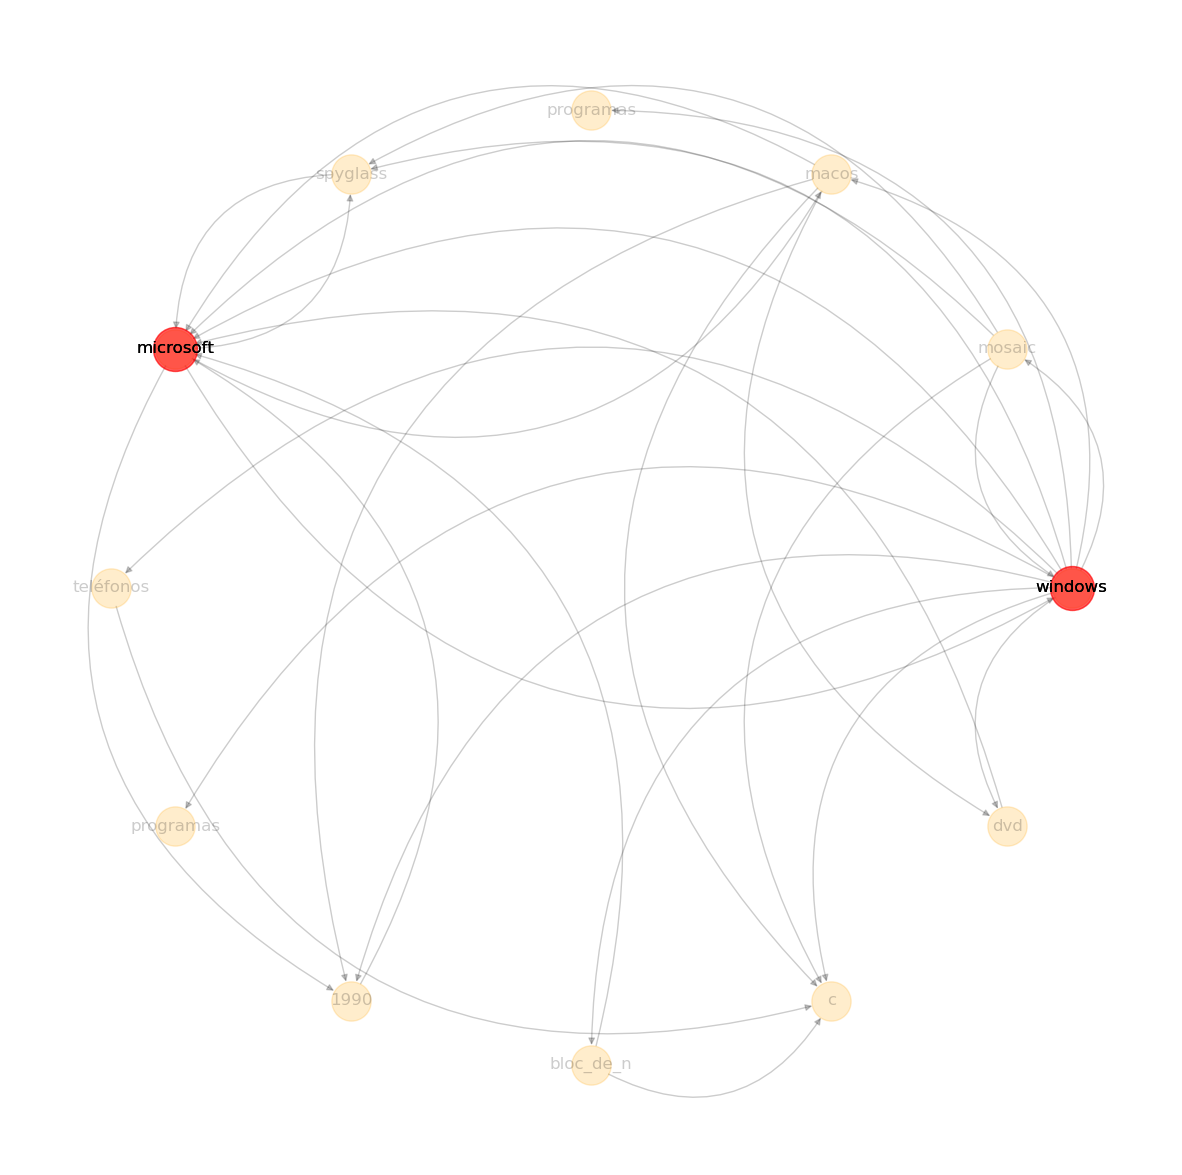

In [10]:
####### EJEMPLO ramificacion CENTRAL ##########
nombre = input("Mande una palabra:")

#lista que va a tener todos los nodos del grafico
nodos = list()
# #lista que contiene los vertices
vertices = list()

# #nodo central
centro = Nodo(nombre)
# # lo agrego a la lista con todos los nodos
nodos.append(centro)

# # obtengo un nodo aleatorio
nodo = Nodo(list(centro.palabras)[random.randrange(0,len(centro.palabras))])
cantidad_nodo = centro

for i in range(20): #cantidad de nodos dibujados
    nodo = Nodo(list(centro.palabras)[random.randrange(0,len(centro.palabras))])
    print(nodo.nombre)
    if (len(nodo.palabras)>0):
        vertices.append((centro, nodo))
        nodos.append(nodo)
    else:
        nodo =  Nodo(random.choice(list(centro.palabras)))

for i in nodos:
     for j in nodos:
        t = i.estaEn(j)
        if t != None:
            vertices.append(t)
        
# layout
fig, ax = plt.subplots(figsize=(15,15))
grafo = nx.DiGraph()

grafo.add_nodes_from(nodos)
grafo.add_edges_from(vertices)
 
pos = nx.circular_layout(grafo)

#Funcion que devuelve los nodos mas importantes
def mas_relevancia(grafo):
#copia de grafo con los nodos mas importantes 
    ranking = nx.betweenness_centrality(grafo).items()
    r = [x[1] for x in ranking]
    m = sum(r)/len(r) # centralidad
    t = m*3 # mantiene los nodos con promedio de aparicion --> si queres que sean mas o menos los coloreados en rojo modifica esto
    nodo_importante = grafo.copy()

    #Se remueve los nodos que no aparecen
    for k, v in ranking:
        if v < t:
            nodo_importante.remove_node(k)
   
    return nodo_importante


#Se recibe los nodos mas importantes
nodo_importante = mas_relevancia(grafo)

nx.draw(grafo,
        pos,
        node_color='orange',
        alpha=0.2,
        node_size=800, 
        with_labels = True, 
        connectionstyle = "arc3, rad=0.5",
        font_size = 12
       )

#Se dibuja los nodos mas importantes con un estilo diferente
for i in range(0,len(nodo_importante)):
    grafo.add_nodes_from(nodo_importante)
    nx.draw_networkx_nodes(nodo_importante,
                           pos,
                           node_color='r',
                           alpha=0.4,
                           node_size=1000)
    nx.draw_networkx_labels(nodo_importante,pos,font_size=12)

#Se muestra la grafica
plt.show()